<a href="https://colab.research.google.com/github/vmendesmagalhaes/machine-learning/blob/main/Prediction_of_the_moisture_content_variation_on_wood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of the moisture content variation on wood

**Author:** Vitor Mendes Magalhaes

**Email:** vitor.mendes.magalhaes@gmail.com

**Last review:** Mar/2023

Wood is the raw material for many manufactured goods. Charcoal, cellulose for the paper industry, laminated wood furniture, and even explosive products, such as gunpowder cotton, are possible destinations for the wood. On the other hand, the growing use of wood as a raw material has increased illegal deforestation and, as a direct consequence, it has changed the climate at a global level.

Regardless of the destination that will be given to the wood logs, many products that have wood as raw material go through the same stage: the storage of logs in piles.

![](https://drive.google.com/uc?export=view&id=1cvJZKoJ-6OyJ74RzLriWSX6rShB2wi5N)

But as the storage time on piles passes, the moisture content on wood will reduce.

The use of wood in production processes must be optimized to mitigate these adverse effects. One of the determining factors for this optimization is moisture content on wood, i.e., the ratio between the mass of water contained in the wood and dry wood mass.

Here, we develop a Artificial Intelligence-based model - specifically using machine learning classification and regression methods - to predict the moisture content on wood, contributing to a better use of the wood in industry.

Let's start by loading the necessary libraries for solving the present applied research problem.

In [ ]:
import pandas as pandas
import numpy as numpy
from numpy import absolute
from numpy import std
from numpy import mean
import matplotlib.pyplot as matplot
import seaborn as seaborn
from sklearn.model_selection import train_test_split as createDataPartition
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import friedmanchisquare

!pip install scikit-posthocs
import scikit_posthocs as sp

import itertools

#!pip install pingouin
#from pingouin import pairwise_ttests, add_custom_posthoc

import warnings
warnings.filterwarnings('ignore')

First of all, we need to ensure the reproducibility of the experiment. Let's do this by setting a seed.

In [2]:
random.seed(7)

The next step is importing the spreadsheet (.XLS file) containing the data.

In [3]:
dados = pandas.read_excel('datasetjan23.xls')

Now we have the data, let's start working on it.

First, let's create a new attribute, called *PERCENTUAL*. It means the percentage of weight loss in relation to the total amount of incoming wood logs in each pile.

In [4]:
dados['PERCENTUAL'] = (dados['ESTORNO'] * 100) / dados['TOT_ENTR']

After creating the new attribute, we will remove the instances of piles that didn't have log outputs (in theory, if they do not represent an operational error, these piles continued to receive loads of wood, or were not yet closed, at the time of data capture).

We will also remove instances of piles that have not had reversed charges, that is, that in theory there was no loss of moisture. In the case of wood logs stored outdoors (technically, it is called "natural drying"), under the conditions of the captured data, there will always be moisture loss.

In [5]:
dados.drop(dados[dados['TOT_SAID'] == 0].index, inplace=True)
dados.drop(dados[dados['ESTORNO'] == 0].index, inplace=True)

After removing the instances, let's create a copy of the original dataset, which will be used to train different problem solving models using supervised learning. We will train classification models.

In [6]:
dfClassificacao = dados

Now, let's start the pre-processing step, removing the attributes that are not interesting for creating the learning models to be applied.

Once this is done, we will continue pre-processing the data, now with a selection of features, removing attributes and biasing the data to conform to the type of supervised learning they propose.

For the development of the classification models, let's create a new attribute, called *INTERVALOPERDA*, meaning the loss ranges. Loss ranges are nothing more than weight loss percentage ranges, eg between 0% and 5% loss; between 5% and 10% loss, and so on, as far as the data allows.

To define the best weight loss percentage ranges, we will first analyze visually, using three different visual analysis tools: a *boxplot*, a summary of the *PERCENTUAL* attribute (which will dictate the ranges), and a histogram with the frequency of instances with different percentages.

<Axes: >

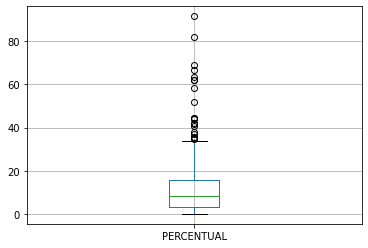

In [ ]:
dfClassificacao.boxplot(column =['PERCENTUAL'], grid = True)

<Axes: >

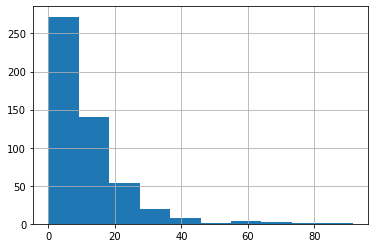

In [ ]:
dfClassificacao['PERCENTUAL'].hist()

In [ ]:
dfClassificacao.describe()

,PILHA,COMPRIMENTO,TEMP_MIN,TEMP_MAX,TEMP_MED,TEMP_PO,PRECIPITACAO,PATM_MED,UR_MIN,UR_MED,VENTO_MED,RAJ_MAX_MED,QTD_DIAS,TOT_ENTR,TOT_SAID,DIFERENCA,ESTORNO,PERCENTUAL
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02,502.000000
mean,380.834661,5.191633,6.353386,30.933068,17.668108,13.021813,230.048207,1015.596673,29.844622,75.807032,3.020159,10.148426,82.864542,2.955402e+05,2.608087e+05,3.473146e+04,3.217752e+04,11.404791
std,201.004887,0.380277,4.468436,6.301451,3.514570,2.811104,204.907322,2.839966,9.870406,4.102414,0.423014,1.044224,70.283867,4.209043e+05,3.530809e+05,8.307838e+04,7.519074e+04,11.723297
min,1.000000,3.900000,1.900000,18.100000,11.640000,6.380000,0.000000,1005.890000,21.000000,64.360000,1.430000,5.700000,0.000000,1.144000e+04,3.030000e+03,-1.996000e+04,2.000000e+01,0.005657
25%,209.250000,5.200000,3.300000,26.700000,14.965000,11.017500,41.400000,1013.885000,21.000000,71.902500,2.700000,9.480000,22.000000,1.312050e+05,1.127950e+05,6.310000e+03,6.310000e+03,3.414372
50%,381.500000,5.200000,5.400000,32.500000,17.395000,12.805000,184.300000,1016.310000,26.000000,76.105000,3.155000,10.440000,69.000000,2.329100e+05,2.047900e+05,1.883000e+04,1.746000e+04,8.179170
75%,556.750000,5.200000,8.600000,34.400000,20.377500,14.797500,392.200000,1016.920000,36.000000,79.260000,3.260000,10.660000,133.750000,3.658750e+05,3.268445e+05,3.958000e+04,3.842550e+04,15.792322
max,722.000000,6.000000,24.000000,39.400000,26.930000,23.340000,1156.000000,1026.700000,70.000000,84.670000,4.630000,14.300000,425.000000,8.128820e+06,6.628260e+06,1.500560e+06,1.500560e+06,91.583333


In a brief analysis, it is noticed that there are possible operational errors that can generate noise in the classification model, allowing them to be considered outliers.

A clear example is the loss percentage. There are percentages that tend to 100%, which does not occur in this process; there are also percentages that tend to 0% - same situation.

So let's remove the instances with losses above 40%.

In [7]:
dfClassificacao = dfClassificacao.drop(dfClassificacao[dados['PERCENTUAL'] >= 40].index)

Afterwards, let's check again through the *boxplot*.

<Axes: >

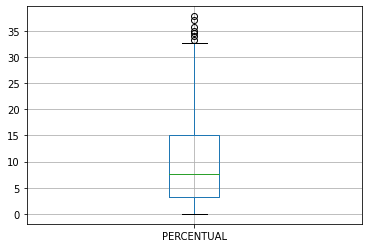

In [ ]:
dfClassificacao.boxplot(column =['PERCENTUAL'], grid = True)

Now we can return to the creation of the attribute *INTERVALOPERDA*, establishing different intervals of loss percentages:

CLASS | INTERVAL
--- | ---
1 | less than 10%
2 | between 10% and 20%
3 | between 20% and 30%
4 | more than 30%

In [8]:
for i, linha in dfClassificacao.iterrows():
  if (linha['PERCENTUAL'] <= 10):
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 1;
  elif ((linha['PERCENTUAL'] > 10) and (linha['PERCENTUAL'] <= 20)):
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 2;
  elif ((linha['PERCENTUAL'] > 20) and (linha['PERCENTUAL'] <= 30)):
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 3;
  else:
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 4;

Once the *INTERVALOPERDA* attribute is created, let's remove the attributes that will not be important for the creation of the learning models - more specifically, the classification.

In this sense, we will remove the stack identification (*PILHA*), the dates (*DATA_INICIO* and *DATA_FIM*, the output weight (*TOT_SAID*), the difference between the input and output totals (*DIFERENCA*) , the amount reversed (*ESTORNO*) and the percentage (*PERCENTUAL*).

Thus, we make it clear that the class we want to predict is the *INTERVALOPERDA*, just created, which contains the interval (in percentage) of wood weight loss.

In [9]:
dfClassificacao = dfClassificacao.drop(["PILHA", "DATA_INICIO", "DATA_FIM", "TOT_SAID", "DIFERENCA", "ESTORNO", "PERCENTUAL"], axis=1)

After creating the attribute (class) that will be our target, and removing the attributes that will not be predictors of our models, we will check the balance of the dataset.

In [ ]:
print(dfClassificacao['INTERVALOPERDA'].value_counts())

1.0    288
2.0    142
3.0     43
4.0     14
Name: INTERVALOPERDA, dtype: int64


We can clearly observe that the largest number of instances is represented in classes 1 and 2, that is, the vast majority of the piles present in the dataset have a weight loss (due to the loss of moisture content) of less than 20%.

We will verify the integrity of these data, analyzing the moisture losses from the piles in relation to the number of days that the logs remained stored (in the same piles).

In [ ]:
print(dfClassificacao['QTD_DIAS'].describe())

count    487.000000
mean      81.266940
std       68.858645
min        0.000000
25%       22.000000
50%       68.000000
75%      127.000000
max      425.000000
Name: QTD_DIAS, dtype: float64


Considering, then, that when it comes to loss of moisture content in wood stored outdoors (*natural drying*) 20% is a small percentage, it can be easily inferred that these logs, due to the large number of days average battery life (81 days), had already been cut longer.

As there are non-numeric predictor attributes, we need to treat them, transforming them into numerical attributes so that we can proceed with the training of the learning models (in Weka, in R and in other environments/languages, this transformation is not necessary, but it is need to analyze possible differences in the prediction result).

Let's do the *one-hot-encoding* for categorical attributes that don't have any need for sorting, like product, bark, and species.

In [10]:
atributos_a_codificar = ['PRODUTO', 'CASCA', 'ESPECIE', 'DIAMETRO']

atributos_codificados = pandas.get_dummies(dfClassificacao[atributos_a_codificar])

dfClassificacao = dfClassificacao.drop(atributos_a_codificar, axis=1).join(atributos_codificados)

Before the next step, it's time to remove the class (*INTERVALOPERDA* attritube) and prepare the dataset to be splitted.

In [11]:
dfClassificacaoTrain = dfClassificacao.drop(["INTERVALOPERDA"], axis=1)

The dataset has not yet been partitioned. The tendency is for the partitions to reproduce the general behavior of the dataset. So let's split it before going ahead.

In [12]:
dados_treino, dados_teste, classe_treino, classe_teste = createDataPartition(dfClassificacaoTrain, dfClassificacao['INTERVALOPERDA'], test_size=0.3, random_state=7)

Thus, with the dataset partitioned with 75% of the data separated for training, and 25% for testing, we can proceed with the training of the models, with the data already biased towards supervised learning - classification.

(we setted a seed to ensure te reprodutibility of the experiment)

Let's then instantiate the classification models using some algorithms. We will use *Random Forest* (RF), *Logistic Regression* (LR), *Support Vector Machines* (SVM), *Gaussian Naive Bayes* (NB), *AdaBoost* (AB), *Gradient Boost* (GB) and *Multi-Layer Perceptrons* (ANN).

In [13]:
rf = RandomForestClassifier()
lr = LogisticRegression()
csvm = svm.LinearSVC()
nb = GaussianNB()
ab = AdaBoostClassifier()
gb = GradientBoostingClassifier()
mlp = MLPClassifier()

Once the models are instantiated, it is time to train the classification models.

In [ ]:
rf.fit(dados_treino, classe_treino)
lr.fit(dados_treino, classe_treino)
csvm.fit(dados_treino, classe_treino)
nb.fit(dados_treino, classe_treino)
ab.fit(dados_treino, classe_treino)
gb.fit(dados_treino, classe_treino)
mlp.fit(dados_treino, classe_treino)

Once the models are trained (using both the training data and the training class), the next step is to verify the predictions, that is, what in fact the created models were able to learn from the available data.

In [15]:
predicoes_rf = rf.predict(dados_teste)
predicoes_lr = lr.predict(dados_teste)
predicoes_svm = csvm.predict(dados_teste)
predicoes_nb = nb.predict(dados_teste)
predicoes_ab = ab.predict(dados_teste)
predicoes_gb = gb.predict(dados_teste)
predicoes_mlp = mlp.predict(dados_teste)

Keeping the predictions in a variable, we will check through a confusion matrix the results of the learning models predictions using classification with RF, LR, SVM, NB, AB, GB and ANN.

In [ ]:
cm_rf = confusion_matrix(classe_teste, predicoes_rf)
cm_lr = confusion_matrix(classe_teste, predicoes_lr)
cm_svm = confusion_matrix(classe_teste, predicoes_svm)
cm_nb = confusion_matrix(classe_teste, predicoes_nb)
cm_ab = confusion_matrix(classe_teste, predicoes_ab)
cm_gb = confusion_matrix(classe_teste, predicoes_gb)
cm_mlp = confusion_matrix(classe_teste, predicoes_mlp)

print("Confusion matrix of RF: \n", cm_rf)
print("Confusion matrix of LR: \n", cm_lr)
print("Confusion matrix of SVM: \n", cm_svm)
print("Confusion matrix of Gaussian Naive Bayes: \n", cm_nb)
print("Confusion matrix of AdaBoost: \n", cm_ab)
print("Confusion matrix of GradientBoost: \n", cm_gb)
print("Confusion matrix of MLP: \n", cm_mlp)

Confusion matrix of RF: 
 [[75 10  1  0]
 [20 22  2  0]
 [ 4  8  1  0]
 [ 1  2  1  0]]
Confusion matrix of LR: 
 [[76 10  0  0]
 [24 20  0  0]
 [ 5  8  0  0]
 [ 1  3  0  0]]
Confusion matrix of SVM: 
 [[ 4 36  5 41]
 [ 2 33  2  7]
 [ 0  9  0  4]
 [ 0  3  0  1]]
Confusion matrix of Gaussian Naive Bayes: 
 [[78  1  7  0]
 [26  4 14  0]
 [ 5  2  6  0]
 [ 1  0  3  0]]
Confusion matrix of AdaBoost: 
 [[72  5  4  5]
 [19 21  3  1]
 [ 3  8  1  1]
 [ 1  0  1  2]]
Confusion matrix of GradientBoost: 
 [[72  9  2  3]
 [20 23  1  0]
 [ 4  6  2  1]
 [ 1  2  1  0]]
Confusion matrix of MLP: 
 [[85  1  0  0]
 [44  0  0  0]
 [13  0  0  0]
 [ 4  0  0  0]]


Observing the confusion matrixes above, we can notice that our models are not good. Before the next step, we need to make the information clearer.

For this, we are going to use some metrics, starting with the accuracy of the models. Accuracy can be described as how much, in percentage, the models are able to hit its predictions (always based on the data that the model had at its disposal).

In [16]:
print("RF accuracy:", metrics.accuracy_score(classe_teste, predicoes_rf))
print("LR accuracy:", metrics.accuracy_score(classe_teste, predicoes_lr))
print("SVM accuracy:", metrics.accuracy_score(classe_teste, predicoes_svm))
print("Naive Bayes accuracy:", metrics.accuracy_score(classe_teste, predicoes_nb))
print("AdaBoost accuracy:", metrics.accuracy_score(classe_teste, predicoes_ab))
print("GradientBoost accuracy:", metrics.accuracy_score(classe_teste, predicoes_gb))
print("MLP accuracy:", metrics.accuracy_score(classe_teste, predicoes_mlp))


RF accuracy: 0.6530612244897959
LR accuracy: 0.6530612244897959
SVM accuracy: 0.14285714285714285
Naive Bayes accuracy: 0.5986394557823129
AdaBoost accuracy: 0.6530612244897959
GradientBoost accuracy: 0.6530612244897959
MLP accuracy: 0.29931972789115646


It is important to keep in mind that, although accuracy is the proportion of correct predictions in relation to the total number of predictions, it is a simple metric, that is, it may not always be the most suitable metric - especially in unbalanced datasets (like this one).

It's time to take a look at the classifiers, trying to tune the hyperparamethers and improve the performance of the developed models. Tuning hyperparameters is an important step to increase the efficiency of the model.

We will use the *GridCV* to search exhaustively over some parameters to (and) get the best possible tune for each one.

In [ ]:
#GridCV do RandomForest
gridCV_rf = {
  	'n_estimators': [5, 10, 20, 50, 100],
		'max_features': ['sqrt', 'log2'],
		'max_depth': [5, 10, 15],
		'max_leaf_nodes': [3, 9, 15]
}

#GridCV do Logistic Regression
gridCV_lr = {
		'C': [0.1, 1, 10, 100],
		'max_iter': [100, 1000, 100000],
		'multi_class': ['auto', 'ovr', 'multinomial']
}

#GridCV do SVM
gridCV_svm = {
		'C': [0.1, 1, 10, 100, 1000],
		'max_iter': [10000, 100000, 500000]
}

#GridCV do Naive Bayes
gridCV_naivebyes = {
		'var_smoothing': numpy.logspace(0,-9, num=100)
}

#GridCV do AdaBoost
gridCV_adaboost = {
  	'n_estimators': [1, 10, 100, 200],
		'algorithm': ['SAMME', 'SAMME.R']
}

#GridCV do GradientBoost
gridCV_gradientboost = {
  	'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
		'max_depth': [5, 6, 7, 8],
		'n_estimators': [1, 10, 100, 200]
}

#GridCV do MLP
gridCV_MLP = {
		'max_iter': [100, 1000, 10000, 100000],
  	'hidden_layer_sizes': [(150, 100, 50), (40, 80, 120), (100, 150, 30), (30, 100, 50, 10)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'learning_rate': ['constant','adaptive']
}


We setted some possible hyperparamethers values, respecting the difference between the different models, and now we will search for the best tuning for the hyperparamethers.

In [ ]:
grid_rf = GridSearchCV(rf, param_grid=gridCV_rf, cv=5)
grid_lr = GridSearchCV(lr, param_grid=gridCV_lr, cv=5)
grid_svm = GridSearchCV(csvm, param_grid=gridCV_svm, cv=5)
grid_nb = GridSearchCV(nb, param_grid=gridCV_naivebyes, cv=5)
grid_ab = GridSearchCV(ab, param_grid=gridCV_adaboost, cv=5)
grid_gb = GridSearchCV(gb, param_grid=gridCV_gradientboost, cv=5)
grid_mlp = GridSearchCV(mlp, param_grid=gridCV_MLP, cv=5)

grid_rf.fit(dados_treino, classe_treino)
grid_lr.fit(dados_treino, classe_treino)
grid_svm.fit(dados_treino, classe_treino)
grid_nb.fit(dados_treino, classe_treino)
grid_ab.fit(dados_treino, classe_treino)
grid_gb.fit(dados_treino, classe_treino)
grid_mlp.fit(dados_treino, classe_treino)

print(grid_rf.best_estimator_)
print(grid_lr.best_estimator_)
print(grid_svm.best_estimator_)
print(grid_nb.best_estimator_)
print(grid_ab.best_estimator_)
print(grid_gb.best_estimator_)
print(grid_mlp.best_estimator_)

RandomForestClassifier(max_depth=5, max_features='log2', max_leaf_nodes=9,
                       n_estimators=5)
LogisticRegression(C=0.1, max_iter=100000)
LinearSVC(C=100, max_iter=100000)
GaussianNB(var_smoothing=8.111308307896856e-09)
AdaBoostClassifier(algorithm='SAMME', n_estimators=1)
GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=200)
MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 150, 30),
              learning_rate='adaptive', max_iter=100000, solver='lbfgs')


And that's it: we already know that the best tuning of the given options for each model. Now we will update the parameters of the models by those obtained above and train again the models.

In [17]:
rf_tunado = RandomForestClassifier(max_depth=5, max_features='log2', max_leaf_nodes=9, n_estimators=5)
lr_tunado = LogisticRegression(C=0.1, max_iter=100000)
svm_tunado = svm.LinearSVC(C=100, max_iter=100000)
nb_tunado = GaussianNB(var_smoothing=8.111308307896856e-09)
ab_tunado = AdaBoostClassifier(algorithm='SAMME', n_estimators=1)
gb_tunado = GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=200)
mlp_tunado = MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 150, 30), learning_rate='adaptive', max_iter=100000, solver='lbfgs')

rf_tunado.fit(dados_treino, classe_treino)
lr_tunado.fit(dados_treino, classe_treino)
svm_tunado.fit(dados_treino, classe_treino)
nb_tunado.fit(dados_treino, classe_treino)
ab_tunado.fit(dados_treino, classe_treino)
gb_tunado.fit(dados_treino, classe_treino)
mlp_tunado.fit(dados_treino, classe_treino)

predicoes_tunadas_rf = rf_tunado.predict(dados_teste)
predicoes_tunadas_lr = lr_tunado.predict(dados_teste)
predicoes_tunadas_svm = svm_tunado.predict(dados_teste)
predicoes_tunadas_nb = nb_tunado.predict(dados_teste)
predicoes_tunadas_ab = ab_tunado.predict(dados_teste)
predicoes_tunadas_gb = gb_tunado.predict(dados_teste)
predicoes_tunadas_MLP = mlp_tunado.predict(dados_teste)

print("Tuned RF accuracy:", metrics.accuracy_score(classe_teste, predicoes_tunadas_rf))
print("Tuned LR accuracy:", metrics.accuracy_score(classe_teste, predicoes_tunadas_lr))
print("Tuned SVM accuracy:", metrics.accuracy_score(classe_teste, predicoes_tunadas_svm))
print("Tuned Naive Bayes accuracy:", metrics.accuracy_score(classe_teste, predicoes_tunadas_nb))
print("Tuned AdaBoost accuracy:", metrics.accuracy_score(classe_teste, predicoes_tunadas_ab))
print("Tuned GradientBoost accuracy:", metrics.accuracy_score(classe_teste, predicoes_tunadas_gb))
print("Tuned MLP accuracy:", metrics.accuracy_score(classe_teste, predicoes_tunadas_MLP))

Tuned RF accuracy: 0.673469387755102
Tuned LR accuracy: 0.6394557823129252
Tuned SVM accuracy: 0.5510204081632653
Tuned Naive Bayes accuracy: 0.5986394557823129
Tuned AdaBoost accuracy: 0.673469387755102
Tuned GradientBoost accuracy: 0.6462585034013606
Tuned MLP accuracy: 0.5850340136054422


With the changes in the hyperparameters tunings, we can see that the trained models, in a general way, had they accuracy increased. Maybe if we had more data (more instances in the dataset), we could get better results.

Let's take a look to another metrics, like *Precision*, *Recall* and *F1-Score*.

In [ ]:
print("Classification report (Random Forest): \n", classification_report(classe_teste, predicoes_rf))
print("Classification report (Logistic Regression): \n", classification_report(classe_teste, predicoes_lr))
print("Classification report (SVM): \n", classification_report(classe_teste, predicoes_svm))
print("Classification report (Naive Bayes): \n", classification_report(classe_teste, predicoes_nb))
print("Classification report (AdaBoost): \n", classification_report(classe_teste, predicoes_ab))
print("Classification report (GradientBoost): \n", classification_report(classe_teste, predicoes_gb))
print("Classification report (MLP): \n", classification_report(classe_teste, predicoes_mlp))

Classification report (Random Forest): 
               precision    recall  f1-score   support

         1.0       0.76      0.88      0.82        86
         2.0       0.56      0.52      0.54        44
         3.0       0.17      0.08      0.11        13
         4.0       0.00      0.00      0.00         4

    accuracy                           0.68       147
   macro avg       0.37      0.37      0.37       147
weighted avg       0.63      0.68      0.65       147

Classification report (Logistic Regression): 
               precision    recall  f1-score   support

         1.0       0.72      0.88      0.79        86
         2.0       0.49      0.45      0.47        44
         3.0       0.00      0.00      0.00        13
         4.0       0.00      0.00      0.00         4

    accuracy                           0.65       147
   macro avg       0.30      0.33      0.32       147
weighted avg       0.57      0.65      0.60       147

Classification report (SVM): 
            

But taking a look to Precision and Recall of the minority classes, they seem to be not so good. It's time to solve the imbalance problem and take a look again.

Let's use the SMOTE library to handle with the imbalance problem.

In [ ]:
sm = SMOTE()

dados_treino_balanced, classe_treino_balanced = sm.fit_resample(dados_treino, classe_treino)

Now we oversampled the `dados_treino` partition - based on majority class - using the SMOTE algorithm.

In [ ]:
dados_treino_balanced.describe()

,COMPRIMENTO,TEMP_MIN,TEMP_MAX,TEMP_MED,TEMP_PO,PRECIPITACAO,PATM_MED,UR_MIN,UR_MED,VENTO_MED,...,DIAMETRO_12 a 20,DIAMETRO_14 a 22,DIAMETRO_20 a 30,DIAMETRO_22 a 32,DIAMETRO_30 a 40,DIAMETRO_32 a 42,DIAMETRO_40 a 60,DIAMETRO_8 a 12,DIAMETRO_8 a 14,DIAMETRO_8 a 20
count,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,...,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000
mean,5.157799,5.390419,33.166885,17.740527,13.060639,309.476252,1015.793976,26.814299,75.668090,3.107150,...,0.319307,0.019802,0.214109,0.007426,0.064356,0.002475,0.013614,0.001238,0.007426,0.022277
std,0.320242,3.560996,5.653590,2.675661,2.150968,194.274154,2.286034,8.301521,3.212642,0.358890,...,0.466497,0.139406,0.410457,0.085905,0.245539,0.049721,0.115953,0.035180,0.085905,0.147675
min,3.900000,1.900000,18.100000,11.760000,6.380000,0.000000,1005.890000,21.000000,64.360000,1.430000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.140409,2.188991,28.614028,15.950000,11.685605,133.247506,1014.667855,21.000000,73.807754,2.945467,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.200000,4.252553,34.400000,17.694773,13.122064,324.716084,1015.960000,21.281516,76.016305,3.190425,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.200000,7.948627,38.442242,19.505458,14.400320,487.082098,1016.774617,32.000000,77.676192,3.275236,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,24.000000,39.400000,26.930000,23.340000,1156.000000,1026.700000,70.000000,84.670000,4.630000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The next step is to train our classifiers again, now with the new balanced data.

In [ ]:
rf_tunado.fit(dados_treino_balanced, classe_treino_balanced)
lr_tunado.fit(dados_treino_balanced, classe_treino_balanced)
svm_tunado.fit(dados_treino_balanced, classe_treino_balanced)
nb_tunado.fit(dados_treino_balanced, classe_treino_balanced)
ab_tunado.fit(dados_treino_balanced, classe_treino_balanced)
gb_tunado.fit(dados_treino_balanced, classe_treino_balanced)
mlp_tunado.fit(dados_treino_balanced, classe_treino_balanced)

At this point, our classifiers are already trained with our balanced data. It's time to get its predictions.

In [ ]:
predicoes_rf_balanced = rf_tunado.predict(dados_teste)
predicoes_lr_balanced = lr_tunado.predict(dados_teste)
predicoes_svm_balanced = svm_tunado.predict(dados_teste)
predicoes_nb_balanced = nb_tunado.predict(dados_teste)
predicoes_ab_balanced = ab_tunado.predict(dados_teste)
predicoes_gb_balanced = gb_tunado.predict(dados_teste)
predicoes_mlp_balanced = mlp_tunado.predict(dados_teste)

Having the predictions, let's take a look at the confusion matrixes using the new balanced data.

In [ ]:
cm_rf_balanced = confusion_matrix(classe_teste, predicoes_rf_balanced)
cm_lr_balanced = confusion_matrix(classe_teste, predicoes_lr_balanced)
cm_svm_balanced = confusion_matrix(classe_teste, predicoes_svm_balanced)
cm_nb_balanced = confusion_matrix(classe_teste, predicoes_nb_balanced)
cm_ab_balanced = confusion_matrix(classe_teste, predicoes_ab_balanced)
cm_gb_balanced = confusion_matrix(classe_teste, predicoes_gb_balanced)
cm_mlp_balanced = confusion_matrix(classe_teste, predicoes_mlp_balanced)

print("Confusion matrix of RF (after balancing the data): \n", cm_rf_balanced)
print("Confusion matrix of LR (after balancing the data): \n", cm_lr_balanced)
print("Confusion matrix of SVM (after balancing the data): \n", cm_svm_balanced)
print("Confusion matrix of Naive Bayes (after balancing the data): \n", cm_nb_balanced)
print("Confusion matrix of AdaBoost (after balancing the data): \n", cm_ab_balanced)
print("Confusion matrix of Gradient Boost (after balancing the data): \n", cm_gb_balanced)
print("Confusion matrix of MLP (after balancing the data): \n", cm_mlp_balanced)

Confusion matrix of RF (after balancing the data): 
 [[74  4  4  4]
 [18 22  4  0]
 [ 4  5  3  1]
 [ 1  1  1  1]]
Confusion matrix of LR (after balancing the data): 
 [[61 13  3  9]
 [17 12  8  7]
 [ 5  4  2  2]
 [ 1  0  0  3]]
Confusion matrix of SVM (after balancing the data): 
 [[ 1 85  0  0]
 [ 0 44  0  0]
 [ 0 13  0  0]
 [ 0  4  0  0]]
Confusion matrix of Naive Bayes (after balancing the data): 
 [[24  7 14 41]
 [ 6  3 14 21]
 [ 2  2  3  6]
 [ 0  0  0  4]]
Confusion matrix of AdaBoost (after balancing the data): 
 [[57  0 29  0]
 [ 9  0 35  0]
 [ 4  0  9  0]
 [ 1  0  3  0]]
Confusion matrix of Gradient Boost (after balancing the data): 
 [[67 13  3  3]
 [21 21  2  0]
 [ 4  5  3  1]
 [ 1  1  1  1]]
Confusion matrix of MLP (after balancing the data): 
 [[71  0  0 15]
 [23  0  0 21]
 [ 8  0  0  5]
 [ 1  0  0  3]]


We can clearly see, taking a look at the confusion matrixes above, that our models are still penalizing the minority class - even after the balancing. Let's take a deeper look at the general accuracy of the new models.

In [ ]:
print("Balanced RF accuracy:", metrics.accuracy_score(classe_teste, predicoes_rf_balanced))
print("Balanced LR accuracy:", metrics.accuracy_score(classe_teste, predicoes_lr_balanced))
print("Balanced SVM accuracy:", metrics.accuracy_score(classe_teste, predicoes_svm_balanced))
print("Balanced NB accuracy:", metrics.accuracy_score(classe_teste, predicoes_nb_balanced))
print("Balanced AB accuracy:", metrics.accuracy_score(classe_teste, predicoes_ab_balanced))
print("Balanced GB accuracy:", metrics.accuracy_score(classe_teste, predicoes_gb_balanced))
print("Balanced MLP accuracy:", metrics.accuracy_score(classe_teste, predicoes_mlp_balanced))

Balanced RF accuracy: 0.6802721088435374
Balanced LR accuracy: 0.5306122448979592
Balanced SVM accuracy: 0.30612244897959184
Balanced NB accuracy: 0.23129251700680273
Balanced AB accuracy: 0.4489795918367347
Balanced GB accuracy: 0.6258503401360545
Balanced MLP accuracy: 0.5034013605442177


Now, let's take a look at the classification reports.

In [ ]:
print("Classification report (Random Forest): \n", classification_report(classe_teste, predicoes_rf_balanced))
print("Classification report (Logistic Regression): \n", classification_report(classe_teste, predicoes_lr_balanced))
print("Classification report (SVM): \n", classification_report(classe_teste, predicoes_svm_balanced))
print("Classification report (Naive Bayes): \n", classification_report(classe_teste, predicoes_nb_balanced))
print("Classification report (AdaBoost): \n", classification_report(classe_teste, predicoes_ab_balanced))
print("Classification report (GradientBoost): \n", classification_report(classe_teste, predicoes_gb_balanced))
print("Classification report (MLP): \n", classification_report(classe_teste, predicoes_mlp_balanced))

Classification report (Random Forest): 
               precision    recall  f1-score   support

         1.0       0.76      0.86      0.81        86
         2.0       0.69      0.50      0.58        44
         3.0       0.25      0.23      0.24        13
         4.0       0.17      0.25      0.20         4

    accuracy                           0.68       147
   macro avg       0.47      0.46      0.46       147
weighted avg       0.68      0.68      0.67       147

Classification report (Logistic Regression): 
               precision    recall  f1-score   support

         1.0       0.73      0.71      0.72        86
         2.0       0.41      0.27      0.33        44
         3.0       0.15      0.15      0.15        13
         4.0       0.14      0.75      0.24         4

    accuracy                           0.53       147
   macro avg       0.36      0.47      0.36       147
weighted avg       0.57      0.53      0.54       147

Classification report (SVM): 
            

Taking a look at the classification reports above, we can say that the class imbalance impacts negatively, given the training of developed models above.

Now, let's apply a statistic test, called "Align Fridman", ignoring the balancing of the classes. At first, we choose the variables we want to compare, model by model, and put them into an array.

We will choose, in this development: accuracy, precision, recall, and F1-score.

At first, we will save our developed classification models inside an array.

*   Accuracy is how close a given set of predictions are to their true value;
*   Precision is the ability of the model not to label as positive a sample that is negative;
*   Recall is the ability of the model to find all the positive samples;
*   F1 is the harmonic mean between precision and recall.

```
PRECISION = TP / (TP + FP)
```
```
RECALL = TP / (TP + FN)
```
```
F1 = 2 * (PRECISION * RECALL) / (PRECISION + RECALL)
```

In [18]:
modelos = [
    rf_tunado,
    lr_tunado,
    svm_tunado,
    nb_tunado,
    ab_tunado,
    gb_tunado,
    mlp_tunado
]

After that, we need to create another array to save the results of the metrics for each developed model.

In [19]:
resultado = []

Now, we are ready to save it all in our array. Let's go through the developed models, checking the results for each metric and storing them in our array.

Note that are some possible values to the *average* parameter in some functions below.

Here are some brief descriptions:

* "micro": calculates the metric globally, considering all the classes. It's usually recommended to problems that deals with imbalanced classes;
* "macro": calculates the metric for each class, ingoring the balancing of the classes. It's recommended when equal weight is wanted to all classes;
* "weighted": calculates the weighted average for each class, given the number of samples in each class. It's recommended when the dataset is imbalanced and more weight to the minority class is wanted.

So, we will use the *weighted* avarage, trying to deal with our imbalanced problem.

In [20]:
for indice, modelo in enumerate(modelos):
    
    modelo.fit(dados_treino, classe_treino)
    predicoes = modelo.predict(dados_teste)
    
    acuracia = accuracy_score(classe_teste, predicoes)
    precisao = precision_score(classe_teste, predicoes, average='weighted')
    revocacao = recall_score(classe_teste, predicoes, average='weighted')
    f1 = f1_score(classe_teste, predicoes, average='weighted')

    resultados_preliminares = {
        'MODELO': str(modelo),
        'ACURACIA': acuracia,
        'PRECISAO': precisao,
        'REVOCACAO': revocacao,
        'F1': f1
    }

    resultado.append(resultados_preliminares)

In [23]:
resultado

[{'MODELO': "RandomForestClassifier(max_depth=5, max_features='log2', max_leaf_nodes=9,\n                       n_estimators=5)",
  'ACURACIA': 0.6802721088435374,
  'PRECISAO': 0.6276884491170206,
  'REVOCACAO': 0.6802721088435374,
  'F1': 0.6475433416609888},
 {'MODELO': 'LogisticRegression(C=0.1, max_iter=100000)',
  'ACURACIA': 0.6394557823129252,
  'PRECISAO': 0.549838168885788,
  'REVOCACAO': 0.6394557823129252,
  'F1': 0.5882025894446712},
 {'MODELO': 'LinearSVC(C=100, max_iter=100000)',
  'ACURACIA': 0.3197278911564626,
  'PRECISAO': 0.6060900550696469,
  'REVOCACAO': 0.3197278911564626,
  'F1': 0.4172335600907029},
 {'MODELO': 'GaussianNB(var_smoothing=8.111308307896856e-09)',
  'ACURACIA': 0.5986394557823129,
  'PRECISAO': 0.5906198504246419,
  'REVOCACAO': 0.5986394557823129,
  'F1': 0.5301020643921356},
 {'MODELO': "AdaBoostClassifier(algorithm='SAMME', n_estimators=1)",
  'ACURACIA': 0.673469387755102,
  'PRECISAO': 0.6005947943207793,
  'REVOCACAO': 0.673469387755102,
  '

At this point, we are ready to start the evaluation stage of our models. We have to decide which one is better to solve the prediction of the moisture content variation on wood problem.

We will start comparing the developed models, looking for statistical differences between them. For this, the most known is the Align-Friedman test, a statistical technique also used - among many other purposes - to compare the performance of machine learning models.

With the Align-Friedman test, we can interpret the p value to determine whether there is a statistically significant difference between the models developed to solve the referred problem.

The Align-Friedman test uses the following null and alternative hypotheses:

* The null hypothesis (H0): the models performance are equal;
* The alternative hypothesis (Ha): at least one model performance is different from the others.

If the p-value is less than a predetermined significance level (usually 5%, or 0.05), the null hypothesis (that the models are equal, by they performance) can be rejected, and thus we can conclude that at least one of the models that was developed is significantly better than the others. Otherwise, the null hypothesis cannot be rejected - this means concluding that all models performed similarly. The statistic generated by the test is a measure of how different the compared models are in terms of their average overall rating across all evaluation metrics.

In [21]:
df_resultado = pandas.DataFrame(resultado)

acuracia = df_resultado['ACURACIA'].values
precisao = df_resultado['PRECISAO'].values
revocacao = df_resultado['REVOCACAO'].values
f1 = df_resultado['F1'].values

f_valor, p_valor = friedmanchisquare(acuracia, precisao, revocacao, f1)

print("F-value of Align-Friedman: ", f_valor)
print("p-value of Align-Friedman: ", p_valor)

F-value of Align-Friedman:  9.95238095238095
p-value of Align-Friedman:  0.018975282112339117


As we can see above, a low p-value, as is the case in question (0.01), indicates that it is highly unlikely that the observed result occurred by chance, reinforcing the evidence against the null hypothesis and in favor of the alternative hypothesis. Therefore, we can reject the null hypothesis and conclude that there is a significant difference between the tested models.

Now it's time to find the best model, based on the four metrics (accuracy, precision, recall and F1-score).

The easier way to select the best model based on various metrics is to use the *model ranking* technique - according to overall performance. One possible approach is to calculate the aggregate score (or overall score) for each model, which is a weighted average of the individual metrics. After that, sort the models in descending order of aggregate score and select the best performing model.

About precision and recall, we used the weighted average. So, we will use the arithmetic mean with equal weights for all metrics.

In [29]:
score_agregado = (acuracia + precisao + revocacao + f1) / 4

for result in resultado:
    result['SCORE_AGREGADO'] = (result['ACURACIA'] + result['PRECISAO'] + result['REVOCACAO'] + result['F1']) / 4

resultados_ordenados = sorted(resultado, key=lambda x: x['SCORE_AGREGADO'], reverse=True)

print("O melhor modelo é: ", resultados_ordenados[0]['MODELO'])
print("O score agregado do melhor modelo é de: ", resultados_ordenados[0]['SCORE_AGREGADO'])

O melhor modelo é:  RandomForestClassifier(max_depth=5, max_features='log2', max_leaf_nodes=9,
                       n_estimators=5)
O score agregado do melhor modelo é de:  0.6589440021162711


Now, we will apply the Bonferroni-Dunn test. To do this, we will sort the models by the aggregated score and, after that, we will create a dataframe based on it.

In [ ]:
resultados_ordenados = sorted(resultado, key=lambda x: x['SCORE_AGREGADO'], reverse=True)

df = pandas.DataFrame(resultados_ordenados)

After that, the Dunn's test is performed. Finally, the best model is identified from the significant differences obtained by Dunn's test.

In [45]:
# executar o teste de Dunn
dunn_result = sp.posthoc_dunn(df, val_col='SCORE_AGREGADO', group_col='MODELO', p_adjust='bonferroni')

# obter as diferenças significativas entre os modelos com um nível de significância de 0.05
diferencas_significativas = dunn_result < 0.05

# identificar o melhor modelo com base nas diferenças significativas
melhores_modelos = diferencas_significativas.sum().sort_values().index[0]

print('O melhor modelo é: ', melhores_modelos)

O melhor modelo é:  AdaBoostClassifier(algorithm='SAMME', n_estimators=1)
